In [1]:
%autosave 300

Autosaving every 300 seconds


In [2]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import scipy
import networkx as nx
import matplotlib.pyplot as plt

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (20, 15)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

C:\Users\Samsung\Anaconda2\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Load the data in dataframes
user = pd.read_excel('user.xlsx')
store = pd.read_excel('store.xlsx')

In [4]:
user.head()

,First Name,Last Name,Ambassador,Professional,Address1,City,State,Country,Zip Code,Total Dollars Spent,Total Number of Orders
0,dana,bratti,NaN,NaN,37 crandon st,melville,New York,United States,'11747,29.99,1
1,Marina,A. Gunst,NaN,NaN,7660 Thousand Oaks Dr,Lincoln,California,United States,'95648,354.62,2
2,Karen,Aalto,NaN,NaN,12 King St,Groveland,Massachusetts,United States,'01834,79.99,1
3,karen,Abbott,NaN,NaN,14008 overcreek pass,little rock,Arkansas,United States,'72211,239.97,1
4,Karen,Abbott,NaN,NaN,14008 overcreek pass,Little rock,Arkansas,United States,'72211,188.97,1


### The zip code in user df seems to be not exactly as we'd like it to be with an **'** before the actual zip

In [5]:
store.head()

,Store Name,Street Address,City,State,Zip Code
0,Aerotech Designs,1132 4th Avenue,Coraopolis,PA,15108
1,All3Sports,8601 Dunwoody Place,Atlanta,GA,30350
2,Athletes Lounge,2671 NW Vaughn St,Portland,OR,97210
3,Berkeley Sports Basement,2727 Milvia,BERKELEY,CA,94703
4,Bicicletta,1480 GULF ROAD,POINT ROBERTS,WA,98281


In [6]:
user.count()

First Name                4096
Last Name                 4101
Ambassador                  89
Professional                 5
Address1                  4101
City                      4101
State                     4101
Country                   4101
Zip Code                  4101
Total Dollars Spent       4101
Total Number of Orders    4101
dtype: int64

In [7]:
store.count()

Store Name        83
Street Address    83
City              83
State             83
Zip Code          83
dtype: int64

### Let's clean the Zip Code in user and store df

In [8]:
def cleanUserZip(x):
    if str(x).find("'")>-1:
        x = x.replace("'","")
        return x
    else:
        return x
user['Zip Code'] = user['Zip Code'].apply(cleanUserZip)

In [9]:
user['Zip Code'] = user['Zip Code'].apply(str)
store['Zip Code']= store['Zip Code'].apply(str)

In [10]:
store[store['Zip Code'].str.len()>5].count()

Store Name        2
Street Address    2
City              2
State             2
Zip Code          2
dtype: int64

In [11]:
store[store['Zip Code'].str.len()>5]

,Store Name,Street Address,City,State,Zip Code
19,Element Multisport,2754 North Clybourn Avenue,Chicago,IL,60614-8470
30,Gear for Multisport,1935 Don Wickham Dr,Clermont,FL,Fl 34711


In [12]:
store.loc[30,'Zip Code']='34711'

In [13]:
user[user['Zip Code'].str.len()>5].count()

First Name                198
Last Name                 198
Ambassador                  0
Professional                0
Address1                  198
City                      198
State                     198
Country                   198
Zip Code                  198
Total Dollars Spent       198
Total Number of Orders    198
dtype: int64

In [14]:
def cleanShortZipLen(x):
    if len(x)<5:
        x = '0'+x
        return x
    else:
        return x
def cleanLongZipLen(x):
    if len(x)>5:
        x = x[:5]
        return x
    else:
        return x

In [15]:
user['Zip Code'] = user['Zip Code'].apply(cleanShortZipLen)
user['Zip Code'] = user['Zip Code'].apply(cleanLongZipLen)
store['Zip Code'] = store['Zip Code'].apply(cleanShortZipLen)
store['Zip Code'] = store['Zip Code'].apply(cleanLongZipLen)

In [16]:
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [17]:
len(states_abbrev.keys())

57

In [18]:
user_states = user.State.unique().tolist()
store_states = store.State.unique().tolist()

### number of unique states in the user and store df

In [19]:
print "User DF states: ",len(user_states)
print "Store DF states: ",len(store_states)

User DF states:  54
Store DF states:  31


### States common in user df and store df with the states_abbrev dict

In [20]:
print "Dict and store df common states: ",len(list(set(states_abbrev.keys())&set(store_states)))
print "Dict and user df common states: ",len(list(set(states_abbrev.values())&set(user_states)))

Dict and store df common states:  30
Dict and user df common states:  51


### Lets see which states are not coming up as common in both dfs

In [21]:
print "store df and dict uncommon states: ",list(set(store_states).difference(states_abbrev.keys()))
print "user df and dict uncommon states: ",list(set(user_states).difference(states_abbrev.values()))

store df and dict uncommon states:  [u'CA ']
user df and dict uncommon states:  [u'Armed Forces Europe', u'Armed Forces Pacific', u'Washington DC']


### Now we clean the data for states

In [22]:
def cleanStoreState(x):
    if str(x).find("CA")>-1:
        x = 'CA'
        return x
    else:
        return x
store['State'] = store['State'].apply(cleanStoreState)

In [23]:
def cleanUserState(x):
    if str(x).find("Washington")>-1:
        x = 'Washington'
        return x
    else:
        return x
user['State'] = user['State'].apply(cleanUserState)

In [24]:
user[user.State.isin(['Armed Forces Europe','Armed Forces Pacific'])]

,First Name,Last Name,Ambassador,Professional,Address1,City,State,Country,Zip Code,Total Dollars Spent,Total Number of Orders
1075,Dianne,Duran,NaN,NaN,PSC 103 Box 719,APO,Armed Forces Europe,United States,09603,99.99,1
1781,Audrey,Hyland,NaN,NaN,Unit 9700 Box 2616,DPO,Armed Forces Europe,United States,09830,249.97,1
1893,Justine,Jordan,NaN,NaN,PSC 559 box 6768,FPO,Armed Forces Pacific,United States,96377,329.95,2
2160,Edith,Lee,NaN,NaN,Unit 8600 Box 1116,DPO,Armed Forces Pacific,United States,96515,159.98,1
3397,Alison,Siepker,NaN,NaN,PSC 903 Box 21005,FPO,Armed Forces Europe,United States,09859,64.98,1
3544,Ashley,Stevens,NaN,NaN,"Unit 5090, Box 5000",DPO,Armed Forces Europe,United States,09265,169.98,1


### We will drop these states from the user df

In [25]:
user_states = user.State.unique().tolist()
store_states = store.State.unique().tolist()

In [26]:
drop_states = list(set(user_states).difference(states_abbrev.values()))

In [27]:
user = user[~user.State.isin(drop_states)]

### Now to make a map we need to get the latitude and longitude coordinates for each zip code

In [28]:
from collections import defaultdict
import json
import requests

In [29]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py
#load in state geometry
state2poly = defaultdict(list)
us_data = requests.get('https://raw.githubusercontent.com/skepticalbayes/DataScience/master/Intro/data/us-states.json')

In [30]:
data = json.loads(us_data.content)
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(ax,stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        ax.fill(xs, ys,color='0.9',zorder=0)
        ax.plot(xs,ys,lw='0.07',color='k',zorder=1)

        
def make_map():
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

#     if states.max() < 2: # colormap for election probabilities 
#         cmap = cm.RdBu
#         vmin, vmax = 0, 1
#     else:  # colormap for electoral votes
#         cmap = cm.binary
#         vmin, vmax = 0, states.max()
#     norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
#         color = cmap(norm(states.ix[state]))
        draw_state(ax,state)

    #add an inset colorbar
#     ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
#     cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
#                                   norm=norm,
#                                   orientation='horizontal')
#     ax1.set_title(label)
#     remove_border(ax, left=False, bottom=False)
#     ax.set_xticks([])
#     ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

### This is how the map looks like

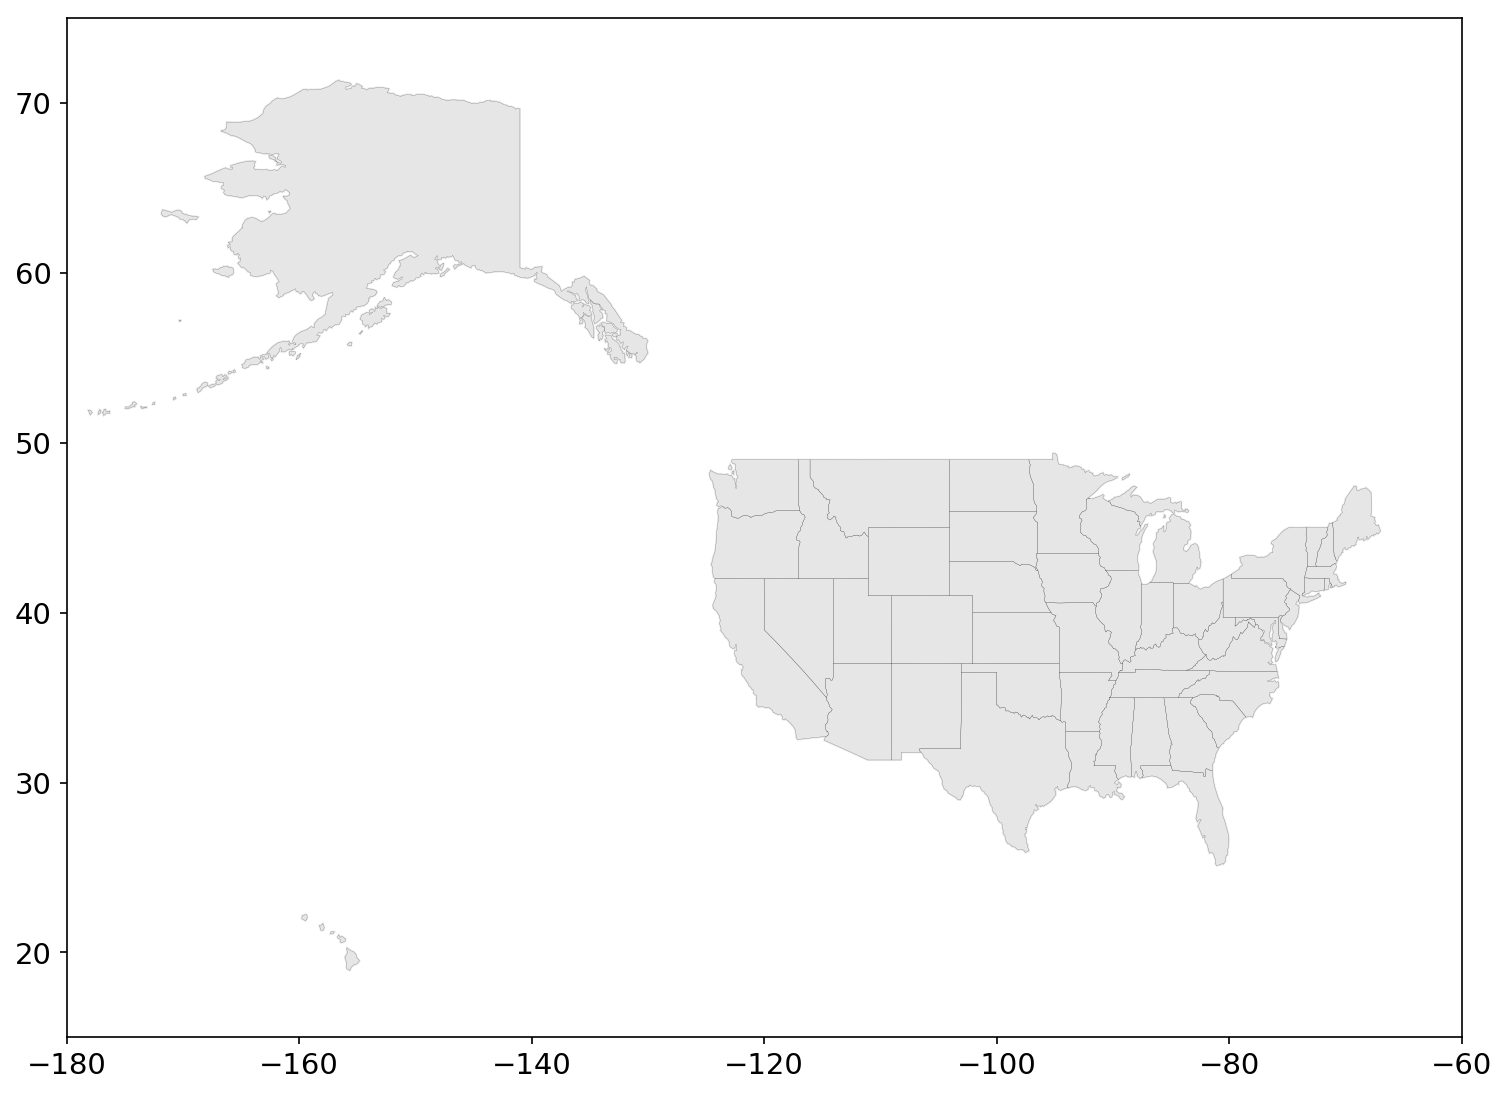

In [31]:
make_map()

### To get the latitude and longitude coordinates for the zip codes we use http://federalgovernmentzipcodes.us/ to get the CSV to get all enlisted zip codes and their lats n longs

*We tried google api and geopy module but there were issues with both so we used the most stable data we could get for free*

In [32]:
df = pd.read_csv('zips.csv')
# http://federalgovernmentzipcodes.us/

In [33]:
df.head()

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,705,STANDARD,AIBONITO,PR,PRIMARY,18.14,-66.26,NA-US-PR-AIBONITO,False,NaN,NaN,NaN
1,610,STANDARD,ANASCO,PR,PRIMARY,18.28,-67.14,NA-US-PR-ANASCO,False,NaN,NaN,NaN
2,611,PO BOX,ANGELES,PR,PRIMARY,18.28,-66.79,NA-US-PR-ANGELES,False,NaN,NaN,NaN
3,612,STANDARD,ARECIBO,PR,PRIMARY,18.45,-66.73,NA-US-PR-ARECIBO,False,NaN,NaN,NaN
4,601,STANDARD,ADJUNTAS,PR,PRIMARY,18.16,-66.72,NA-US-PR-ADJUNTAS,False,NaN,NaN,NaN


### We need to clean the Zip codes in the database

In [34]:
df.Zipcode = df.Zipcode.apply(str)
def applyFixZips(x):
    if len(x)==3:
        x = '00'+x
        return x
    elif len(x)==4:
        x='0'+x
        return x
    else:
        return x
df.Zipcode = df.Zipcode.apply(applyFixZips)

In [35]:
df.head()

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,00705,STANDARD,AIBONITO,PR,PRIMARY,18.14,-66.26,NA-US-PR-AIBONITO,False,NaN,NaN,NaN
1,00610,STANDARD,ANASCO,PR,PRIMARY,18.28,-67.14,NA-US-PR-ANASCO,False,NaN,NaN,NaN
2,00611,PO BOX,ANGELES,PR,PRIMARY,18.28,-66.79,NA-US-PR-ANGELES,False,NaN,NaN,NaN
3,00612,STANDARD,ARECIBO,PR,PRIMARY,18.45,-66.73,NA-US-PR-ARECIBO,False,NaN,NaN,NaN
4,00601,STANDARD,ADJUNTAS,PR,PRIMARY,18.16,-66.72,NA-US-PR-ADJUNTAS,False,NaN,NaN,NaN


### Getting the Lats n Longs for the store and user DF

In [36]:
df['Zip Code'] = df.Zipcode
df['city'] = df.City
df['state'] = df.State
df = df[['Zip Code','city','state','Lat','Long']]
store_df = store.merge(df,how='left',on=['Zip Code'])

In [37]:
user_df = user.merge(df,how='left',on=['Zip Code'])

### Still issues persist with the Data so we go on and fix it

In [38]:
store_df[store_df.city.isnull()]

,Store Name,Street Address,City,State,Zip Code,city,state,Lat,Long
47,MACK CYCLE AND FITNESS,5995 Sunset Drive,South Miami,FL,22143,NaN,NaN,NaN,NaN


In [39]:
user_df[user_df.city.isnull()]

,First Name,Last Name,Ambassador,Professional,Address1,City,State,Country,Zip Code,Total Dollars Spent,Total Number of Orders,city,state,Lat,Long
794,Teresa,Copeland,NaN,NaN,2355 NW Labiche LN,Bend,Oregon,United States,97703,59.97,3,NaN,NaN,NaN,NaN
945,Joan,DeFrances,NaN,NaN,80 Serafin Court,Hamden,Connecticut,United States,06528,79.99,1,NaN,NaN,NaN,NaN
2289,Emma,Maaranen,NaN,NaN,1117 NW Federal St.,Bend,Oregon,United States,97703,144.99,2,NaN,NaN,NaN,NaN
2613,Stephanie,Morris,NaN,NaN,8200 Meadow Ridge,Clarkston,Michigan,United States,84348,131.96,4,NaN,NaN,NaN,NaN
3968,Tori,WILLIAMS,NaN,NaN,3779 W Elk Valley Lane,South Jordan,Utah,United States,84009,289.97,1,NaN,NaN,NaN,NaN


In [40]:
user_df.loc[794,'Lat']=44.06
user_df.loc[794,'Long']=-121.34
user_df.loc[945,'Lat']=41.41
user_df.loc[945,'Long']=-72.91
user_df.loc[2289,'Lat']=44.06
user_df.loc[2289,'Long']=-121.34
user_df.loc[2613,'Lat']=42.75
user_df.loc[2613,'Long']=-83.46
user_df.loc[3968,'Lat']=40.57
user_df.loc[3968,'Long']=-111.98

In [41]:
store_df.loc[47,'Lat']=25.70
store_df.loc[47,'Long']=-80.29

### Getting the data final and ready for analysis

In [42]:
user_df = user_df[['First Name','Last Name','Ambassador','Professional','Address1','City','State','Country','Zip Code','Total Dollars Spent','Total Number of Orders','Lat','Long']]
store_df = store_df[['Store Name','Street Address','City','State','Zip Code','Lat','Long']]

In [43]:
store_df.head()

,Store Name,Street Address,City,State,Zip Code,Lat,Long
0,Aerotech Designs,1132 4th Avenue,Coraopolis,PA,15108,40.51,-80.16
1,All3Sports,8601 Dunwoody Place,Atlanta,GA,30350,33.97,-84.32
2,Athletes Lounge,2671 NW Vaughn St,Portland,OR,97210,45.55,-122.73
3,Berkeley Sports Basement,2727 Milvia,BERKELEY,CA,94703,37.86,-122.27
4,Bicicletta,1480 GULF ROAD,POINT ROBERTS,WA,98281,48.98,-123.05


### Separating out the Ambassadors, Professionals and Customers(All users except the Ambassadors and Customers) as we want to analyse the impact of Ambassadors/Professionals on the average user.

In [44]:
amb_df = user_df[user_df.Ambassador.notnull()]
pro_df = user_df[user_df.Professional.notnull()]
cust_df = user_df[(user_df.Professional.isnull())&(user_df.Ambassador.isnull())] # The users which are not ambassadors or professionals

## Now we create a map of all the users, ambassadors, professionals and the stores

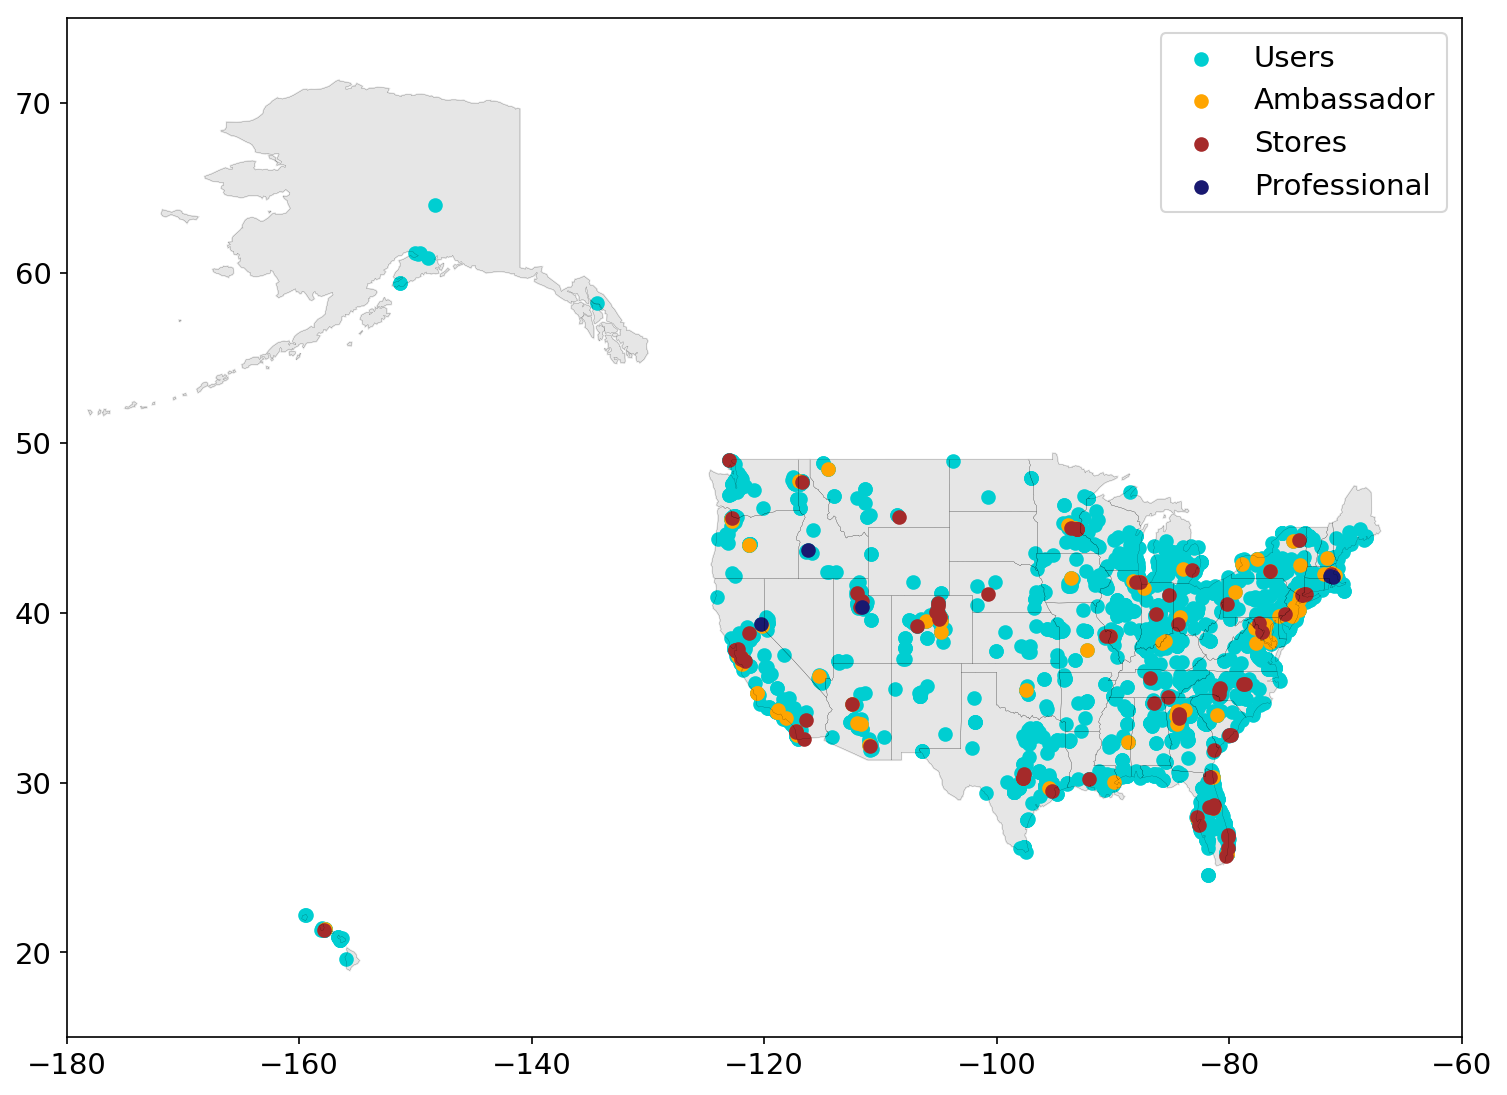

In [45]:
ax = make_map()
ax.scatter(user_df.Long,user_df.Lat,label='Users',color='darkturquoise')
ax.scatter(amb_df.Long,amb_df.Lat,color='orange',label='Ambassador')
ax.scatter(store_df.Long,store_df.Lat,color='brown',label='Stores')
ax.scatter(pro_df.Long,pro_df.Lat,color='midnightblue',label='Professional',zorder=1)
ax.legend()
plt.show()

In [46]:
import geopy

### Grouping the data by DMAs and aggreate the spendings and purchases in each dma

In [47]:
user_grp = user_df.groupby('Zip Code',as_index=False).agg({'Total Dollars Spent':'sum','Total Number of Orders':'sum'})

In [48]:
cust_grp = cust_df.groupby('Zip Code',as_index=False).agg({'Total Dollars Spent':'sum','Total Number of Orders':'sum'})

In [49]:
cust_grp.count()

Zip Code                  2660
Total Dollars Spent       2660
Total Number of Orders    2660
dtype: int64

In [50]:
user_grp.count()

Zip Code                  2697
Total Dollars Spent       2697
Total Number of Orders    2697
dtype: int64

### Now we have to get the Lat and Long from our DF to the new segragated DF

In [51]:
# function to get Lat and Long data for each DMA
def get_coords(df):
    df_pos = df[['Zip Code','Lat','Long']]
    df_pos.drop_duplicates(inplace=True)
    return df_pos

In [52]:
cust_coords = get_coords(cust_df)
user_coords = get_coords(user_df)

C:\Users\Samsung\Anaconda2\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [53]:
# user_coords.count()
cust_coords.count()

Zip Code    2660
Lat         2660
Long        2660
dtype: int64

In [54]:
user_grp = user_grp.merge(user_coords,how='left',on='Zip Code')
user_grp.count()

Zip Code                  2697
Total Dollars Spent       2697
Total Number of Orders    2697
Lat                       2697
Long                      2697
dtype: int64

In [55]:
cust_grp = cust_grp.merge(cust_coords,how='left',on='Zip Code')
cust_grp.count()

Zip Code                  2660
Total Dollars Spent       2660
Total Number of Orders    2660
Lat                       2660
Long                      2660
dtype: int64

In [56]:
amb_pos = get_coords(amb_df)
amb_coords = [tuple(x) for x in amb_pos[['Lat','Long']].values]

In [57]:
len(amb_coords)

86

In [58]:
user_grp.head()

,Zip Code,Total Dollars Spent,Total Number of Orders,Lat,Long
0,01033,169.98,1,42.26,-72.52
1,01036,59.99,1,42.06,-72.41
2,01062,241.98,3,42.32,-72.67
3,01532,705.87,9,42.31,-71.64
4,01545,104.98,1,42.30,-71.71


In [59]:
from geopy.distance import great_circle

In [60]:
# We get the number of Amabassadors within 25 miles of each DMA
amb_count = []
for usr_loc in user_grp[['Lat','Long']].values:
    usr_coords = tuple(usr_loc)
    count = 0
    for amb_coord in amb_coords:
        dist = great_circle(usr_coords,amb_coord).miles
        if dist<=25:
            count = count+1
    amb_count.append(count)

In [61]:
user_grp['Nearby Ambassadors'] = amb_count

In [62]:
# We get the number of Amabassadors within 25 miles of each DMA
amb_count = []
for cust_loc in cust_grp[['Lat','Long']].values:
    cust_coords = tuple(cust_loc)
    count = 0
    for amb_coord in amb_coords:
        dist = great_circle(cust_coords,amb_coord).miles
        if dist<=25:
            count = count+1
    amb_count.append(count)

In [63]:
cust_grp['Nearby Ambassadors'] = amb_count

### We see the correlation between Total Dollars Spent and Total number of Orders

In [64]:
cust_df.corr()

,Total Dollars Spent,Total Number of Orders,Lat,Long
Total Dollars Spent,1.000000,0.794274,0.000783,-0.001415
Total Number of Orders,0.794274,1.000000,0.001507,0.009562
Lat,0.000783,0.001507,1.000000,0.086118
Long,-0.001415,0.009562,0.086118,1.000000


##### This suggets a strong correlation between Total Dollars Spent and Total Number of Orders

## Now we see if these two groups are really diferent or not

### Creating DF for DMAs with no ambassadors within 25 miles

In [65]:
tmp_nAdf = cust_grp[cust_grp['Nearby Ambassadors']==0]
print "Total DMAS with no nearby ambassadors: ", len(tmp_nAdf)
print "Average earning per such DMA: ", tmp_nAdf['Total Dollars Spent'].mean()
print "Average orders per such DMA: ", tmp_nAdf['Total Number of Orders'].mean()

Total DMAS with no nearby ambassadors:  1464
Average earning per such DMA:  250.798654372
Average orders per such DMA:  2.34426229508


### We see the distribution for the purchases and spendings

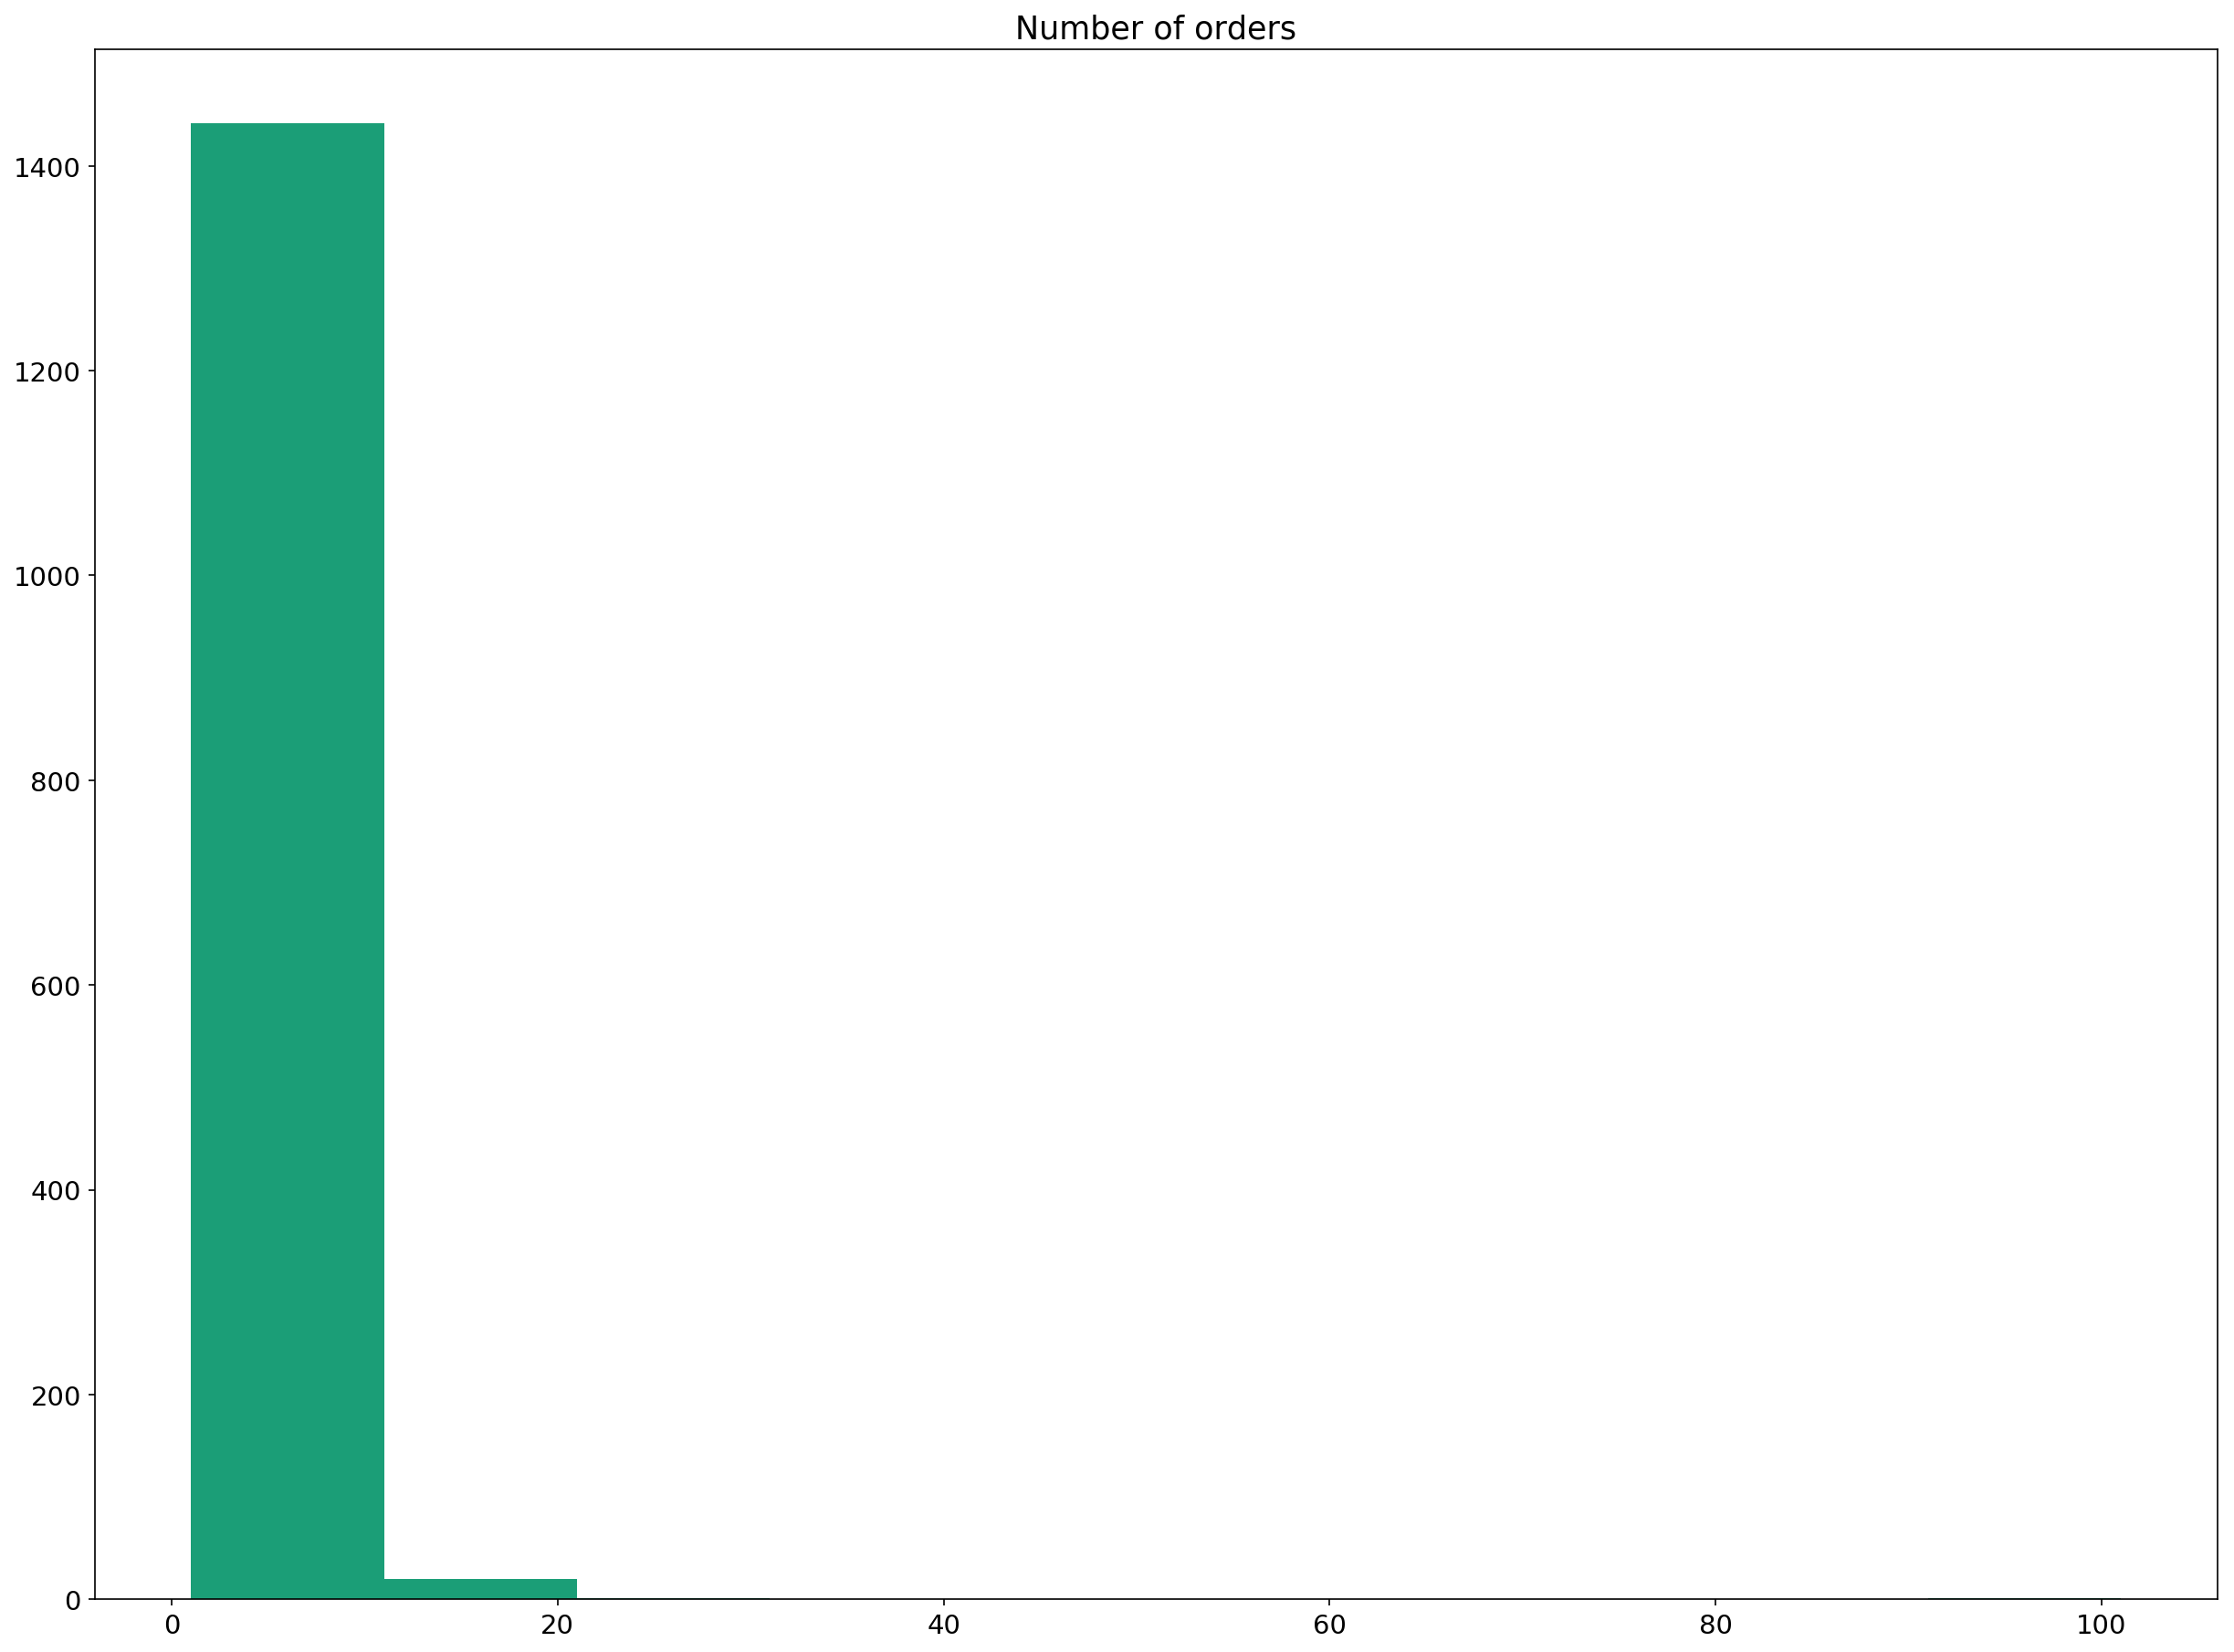

In [66]:
plt.hist(tmp_nAdf['Total Number of Orders'])
plt.title('Number of orders')
plt.show()

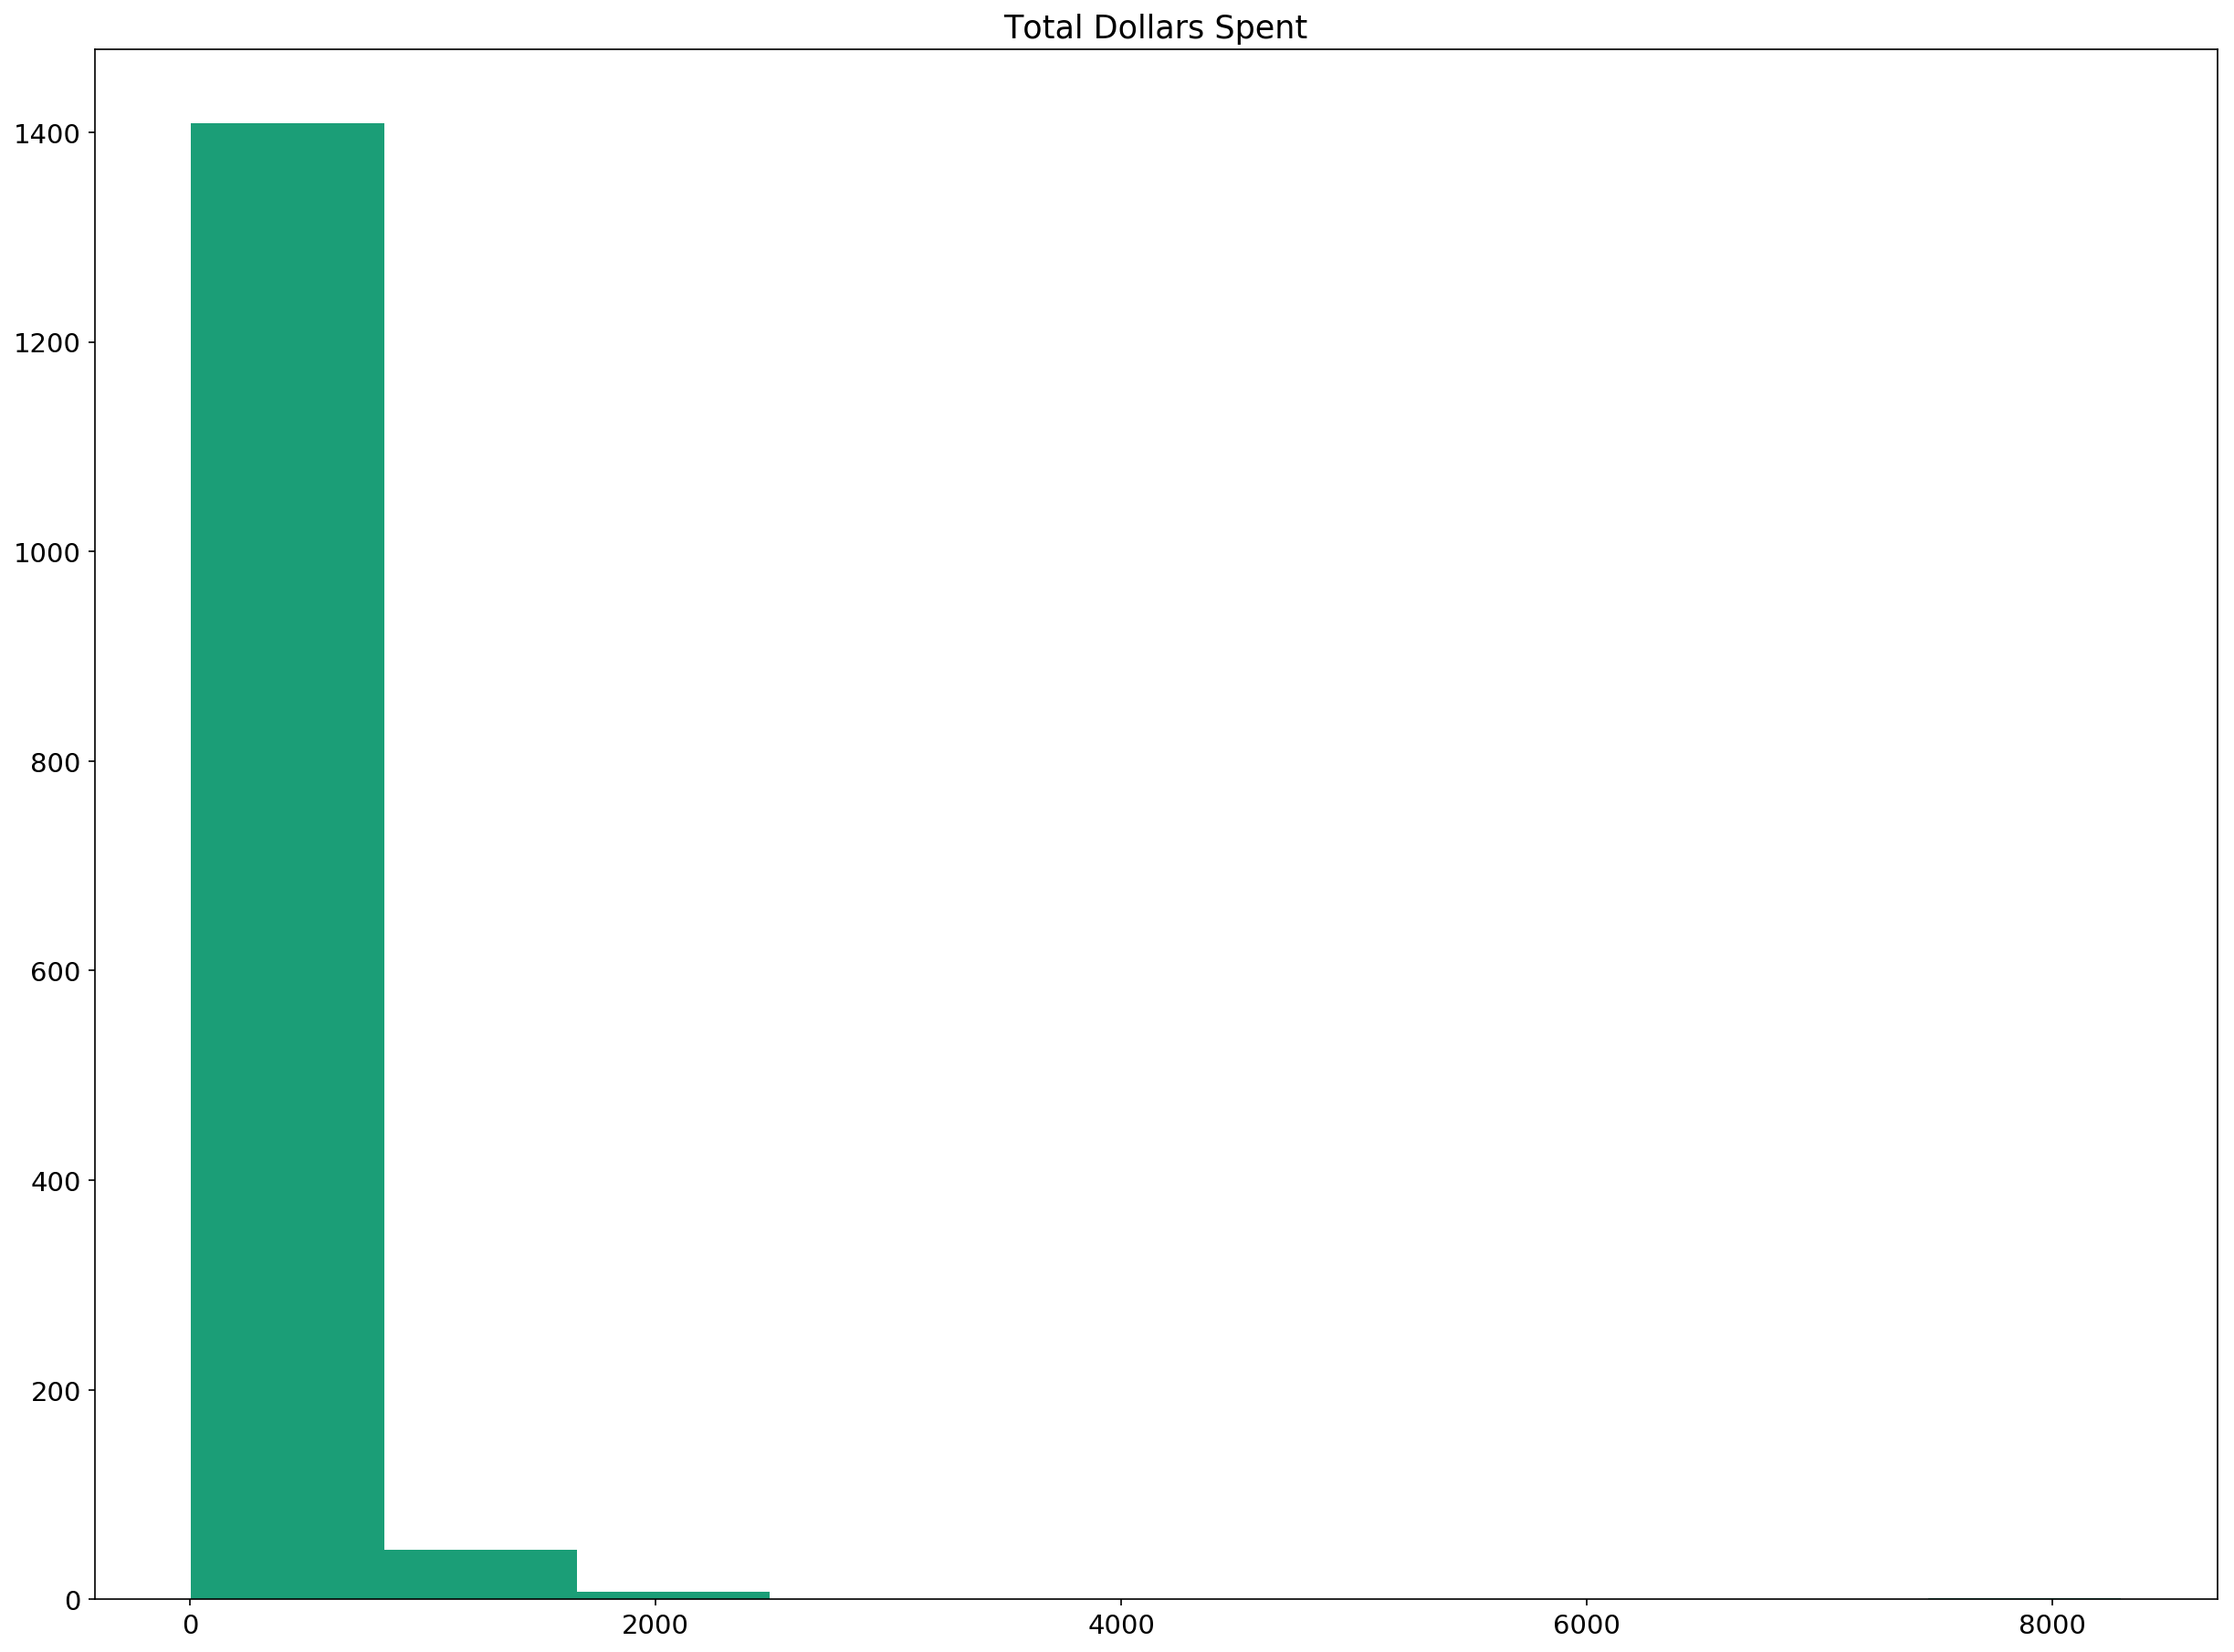

In [67]:
plt.hist(tmp_nAdf['Total Dollars Spent'])
plt.title('Total Dollars Spent')
plt.show()

### Now we create a DF for the customers with an ambassador nearby

In [68]:
tmp_Adf = cust_grp[cust_grp['Nearby Ambassadors']>0]
print "Total DMAS with no nearby ambassadors: ", len(tmp_Adf)
print "Average earning per such DMA: ", tmp_Adf['Total Dollars Spent'].mean()
print "Average orders per such DMA: ", tmp_Adf['Total Number of Orders'].mean()

Total DMAS with no nearby ambassadors:  1196
Average earning per such DMA:  303.685091973
Average orders per such DMA:  2.8143812709


### And visualize the distribution of the spendings and purchases in those DMAs

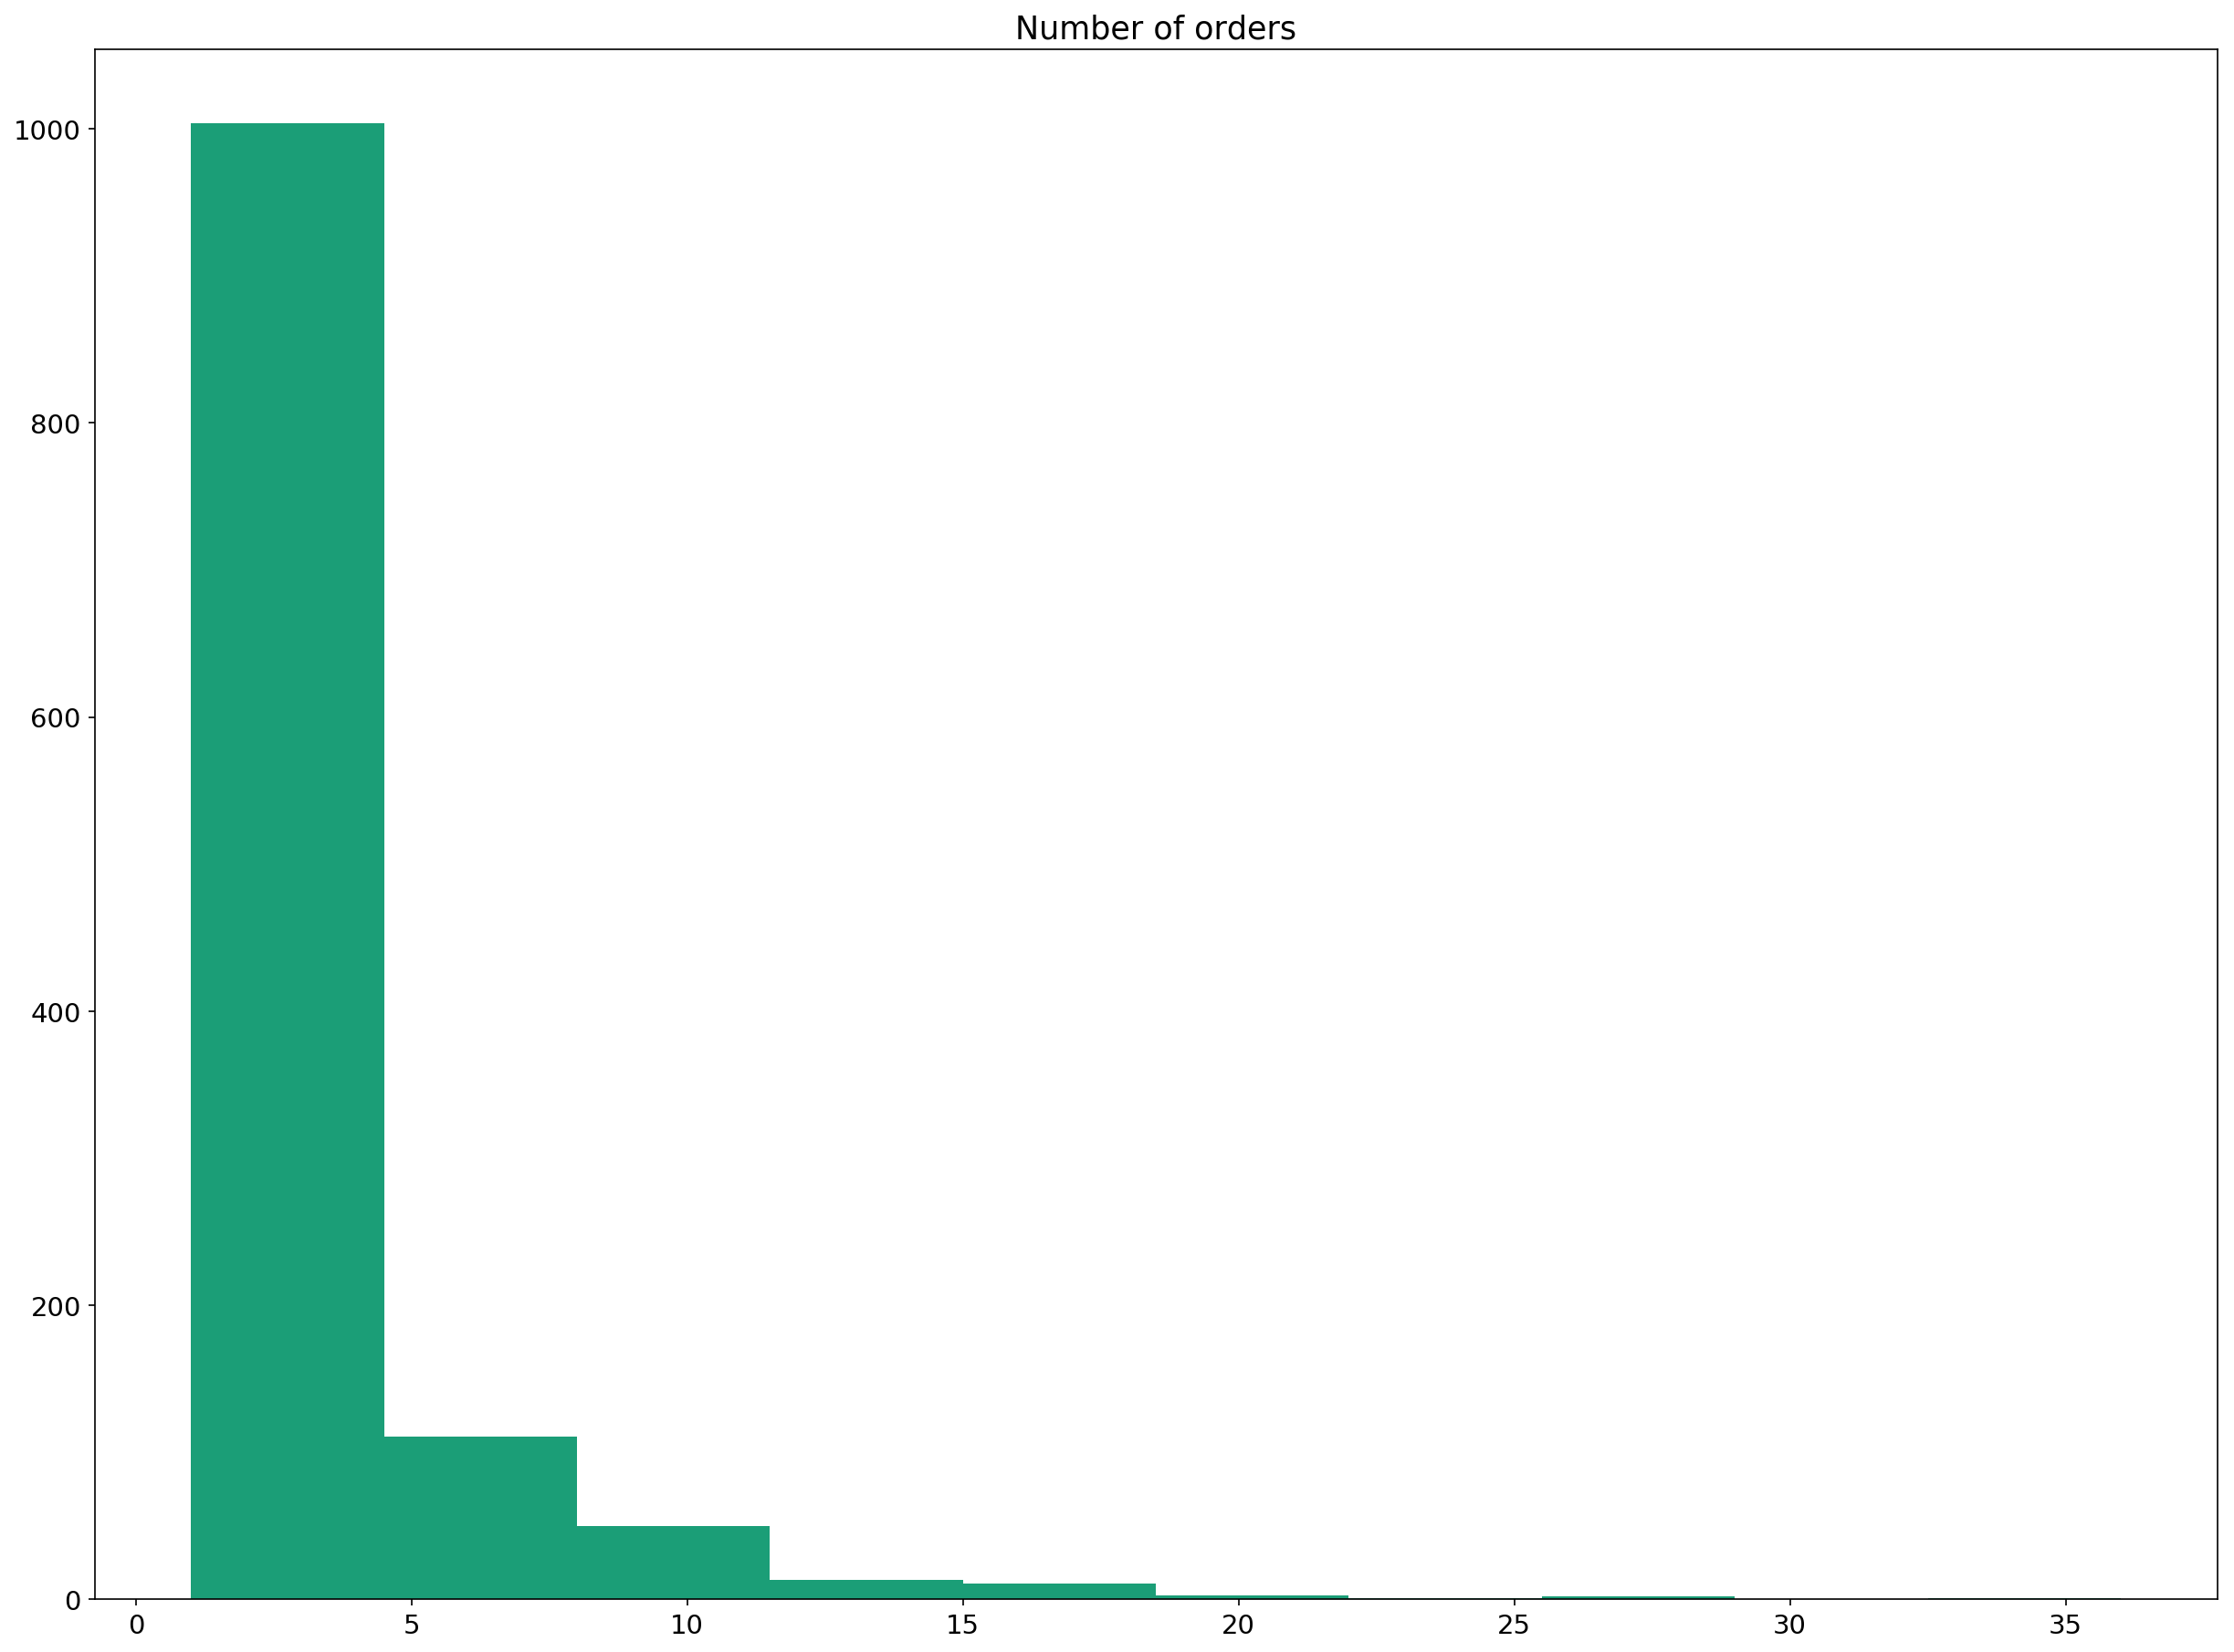

In [69]:
plt.hist(tmp_Adf['Total Number of Orders'])
plt.title('Number of orders')
plt.show()

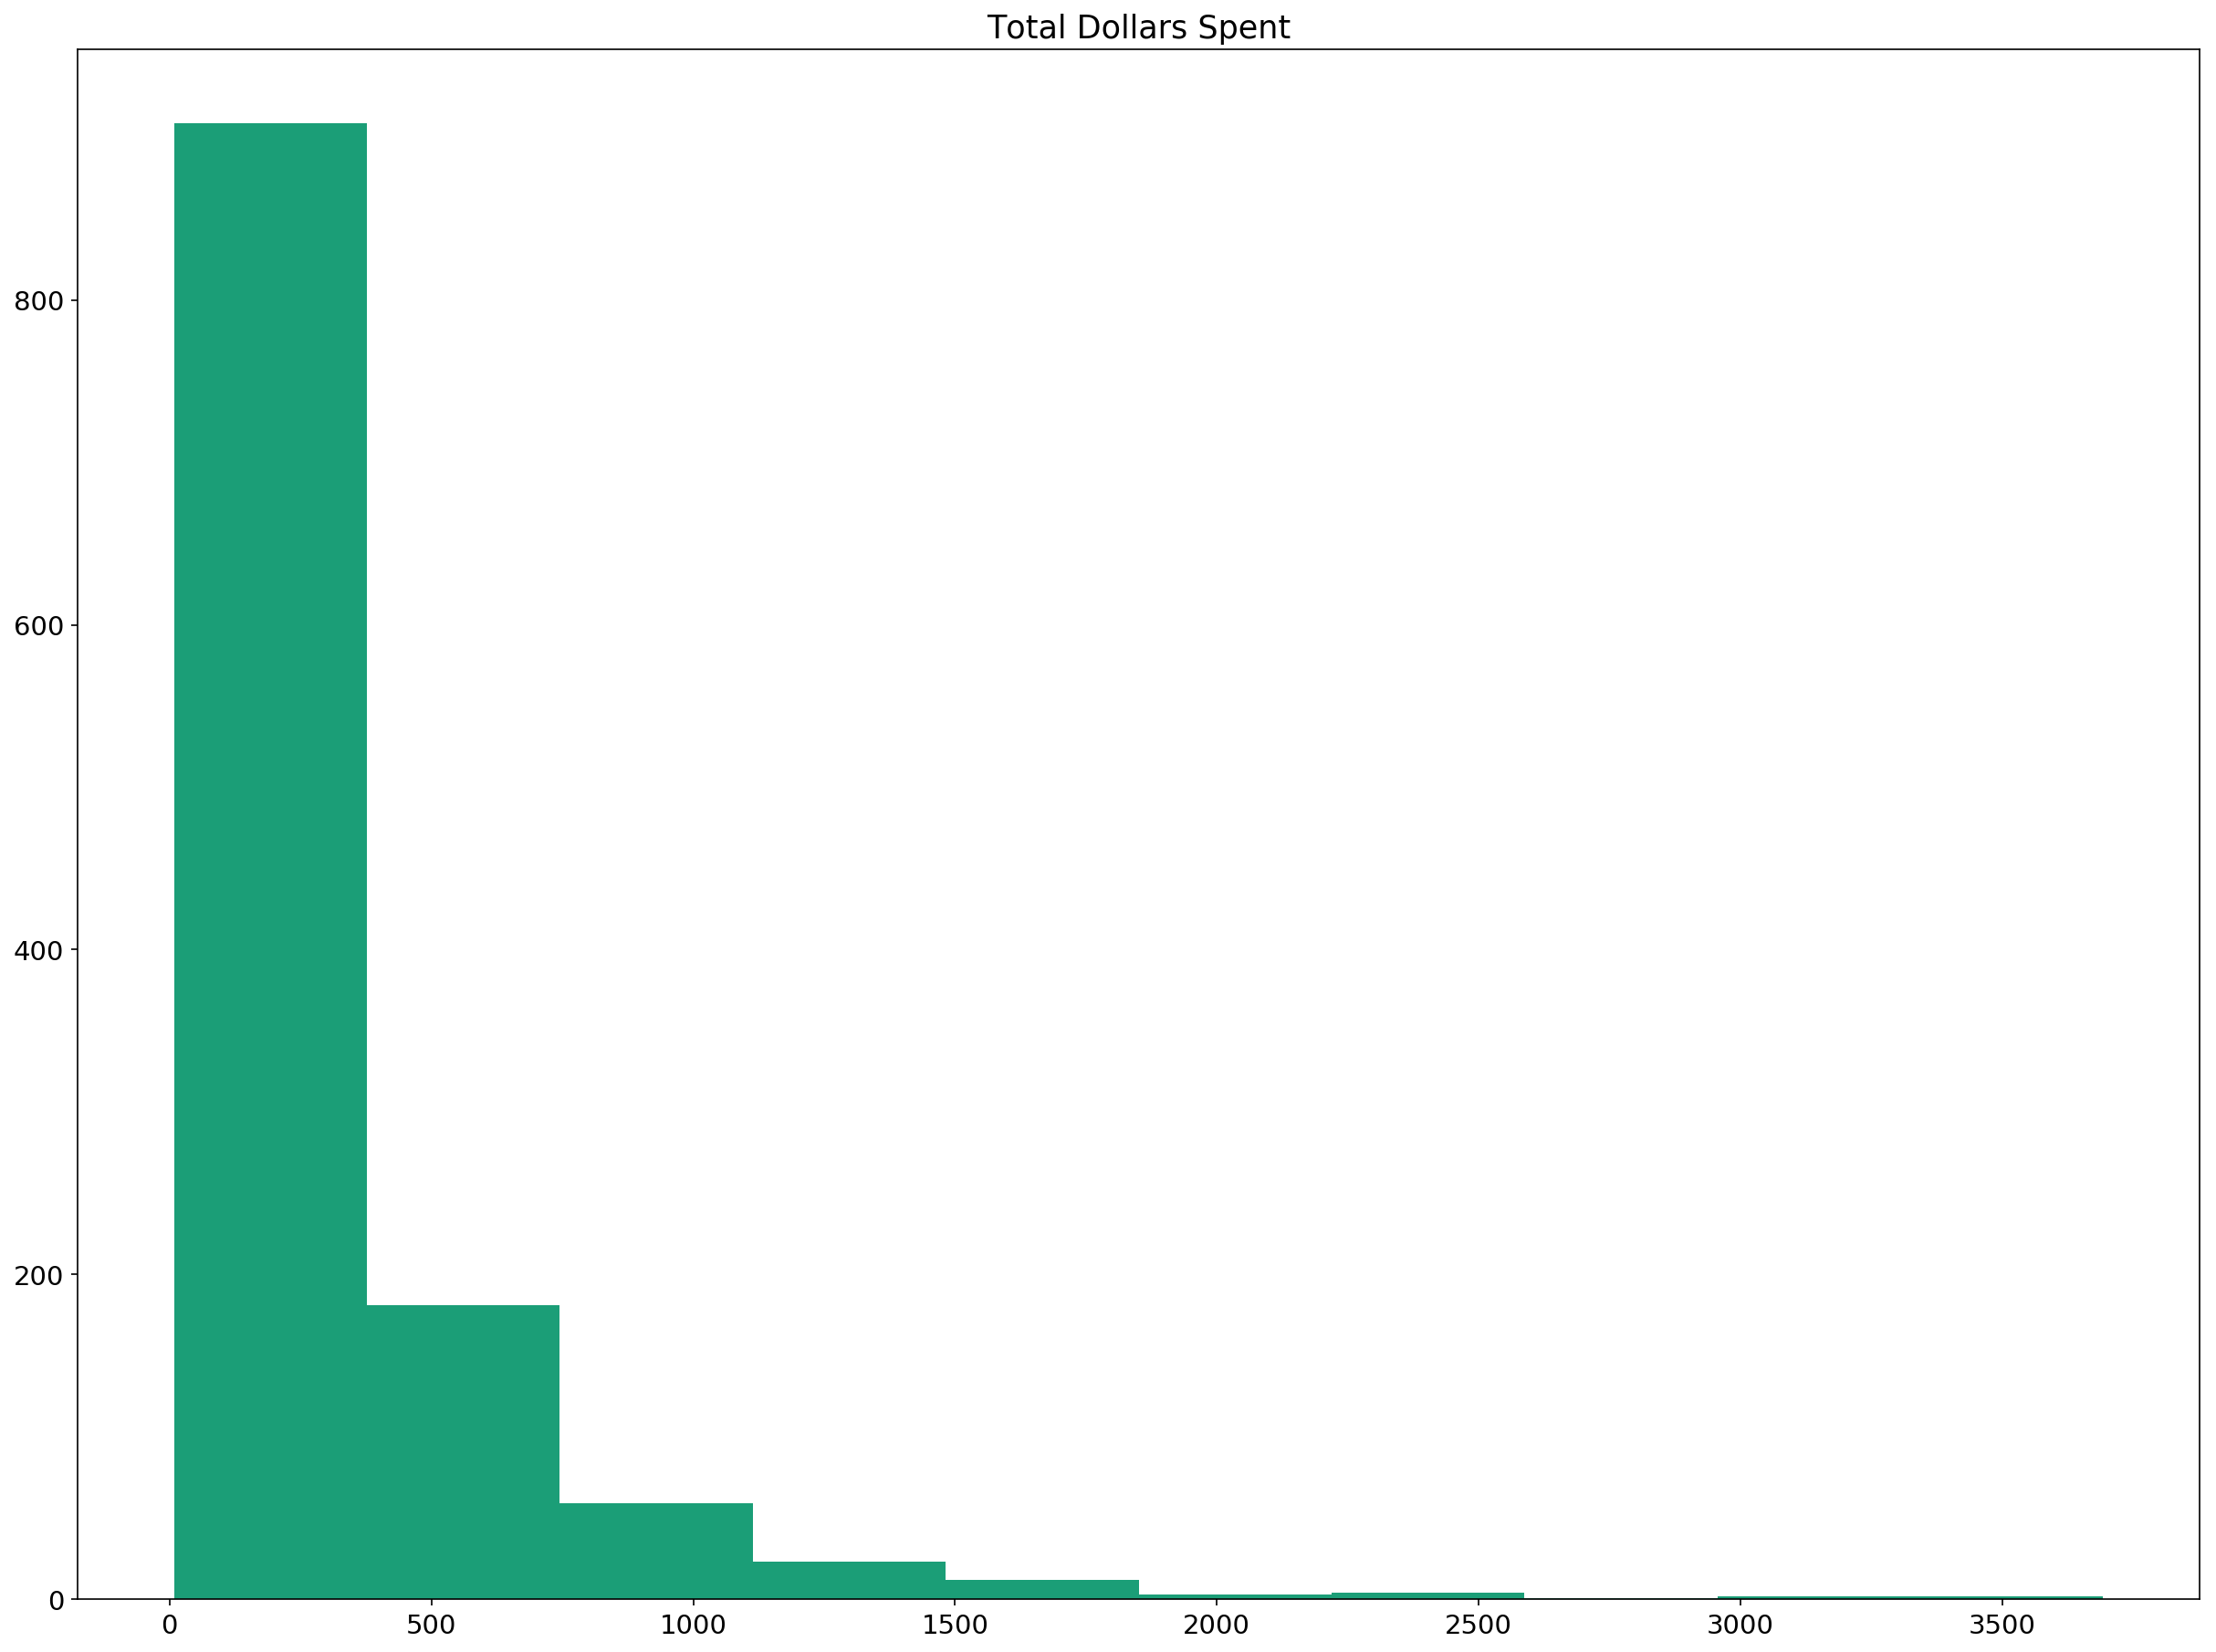

In [70]:
plt.hist(tmp_Adf['Total Dollars Spent'])
plt.title('Total Dollars Spent')
plt.show()

### Now we calculate the T-test for the means of the two groups. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

In [71]:
from scipy import stats
stats.ttest_ind(tmp_Adf['Total Dollars Spent'],tmp_nAdf['Total Dollars Spent'],equal_var = False)

Ttest_indResult(statistic=3.7871041915762582, pvalue=0.00015616277842561067)

In [72]:
print "Average spending in a DMA with an Ambassador nearby: ",tmp_Adf['Total Dollars Spent'].mean()

Average spending in a DMA with an Ambassador nearby:  303.685091973


In [73]:
print "Average spending in a DMA with no Ambassador nearby: ",tmp_nAdf['Total Dollars Spent'].mean()

Average spending in a DMA with no Ambassador nearby:  250.798654372


In [74]:
stats.ttest_ind(tmp_Adf['Total Number of Orders'],tmp_nAdf['Total Number of Orders'],equal_var = False)

Ttest_indResult(statistic=3.6752498365270938, pvalue=0.00024237873722485654)

In [75]:
print "Average purchases in a DMA with an Ambassador nearby: ",tmp_Adf['Total Number of Orders'].mean()

Average purchases in a DMA with an Ambassador nearby:  2.8143812709


In [76]:
print "Average purchases in a DMA with no Ambassador nearby: ",tmp_nAdf['Total Number of Orders'].mean()

Average purchases in a DMA with no Ambassador nearby:  2.34426229508


##### This tells us that the DMAs with an Ambassador within 25 miles definitely benefits from the ambassador's presence

### Now we see what effect multiple amabassadors have in a single DMA rather than just one

In [77]:
amb_grp = amb_df.groupby('Zip Code',as_index=False).agg({'Ambassador':'count'})
amb_grp.count()

Zip Code      86
Ambassador    86
dtype: int64

In [78]:
pro_grp = pro_df.groupby('Zip Code',as_index=False).agg({'Professional':'count'})
pro_grp.count()

Zip Code        5
Professional    5
dtype: int64

In [79]:
cust_zips = cust_grp['Zip Code'].unique().tolist()
amb_zips = amb_grp["Zip Code"].unique().tolist()
pro_zips = pro_grp['Zip Code'].unique().tolist()

In [80]:
common_amb_zips=list(set(cust_zips)&set(amb_zips))

In [81]:
common_pro_zips=list(set(cust_zips)&set(pro_zips))

In [82]:
amb_merge=amb_grp[amb_grp['Zip Code'].isin(common_amb_zips)]
pro_merge=pro_grp[pro_grp['Zip Code'].isin(common_pro_zips)]
cust_grp_tmp = cust_grp.merge(amb_merge,how='left',on='Zip Code')
cust_grp_tmp = cust_grp_tmp.merge(pro_merge,how='left',on='Zip Code')

In [83]:
cust_grp_tmp.fillna(0,inplace=True)

In [84]:
tmp_nA = cust_grp_tmp[cust_grp_tmp.Ambassador==0] #Df with 0 Ambassador
tmp_A = cust_grp_tmp[cust_grp_tmp.Ambassador==1] #Df with 1 Ambassador
tmp_mA = cust_grp_tmp[cust_grp_tmp.Ambassador>1] #Df with >1 Ambassador
tmp_p = cust_grp_tmp[cust_grp_tmp.Professional>0] #Df with >0 Pro

In [85]:
tmp_aA = cust_grp_tmp[cust_grp_tmp.Ambassador>0] #Df with >0 Ambassador

#### T test between DMAs with a single ambassador and DMAs with multiple ambassadors

In [86]:
stats.ttest_ind(tmp_A['Total Dollars Spent'],tmp_mA['Total Dollars Spent'],equal_var=False)

Ttest_indResult(statistic=-0.75584601438245558, pvalue=0.58704740827806412)

In [87]:
# Total Dollars Spent Total Number of Orders
stats.ttest_ind(tmp_A['Total Number of Orders'],tmp_mA['Total Number of Orders'],equal_var=False)

Ttest_indResult(statistic=-0.68209537080353488, pvalue=0.617172777639311)

In [88]:
print "Average purchases in a DMA with one Ambassador: ",tmp_A['Total Number of Orders'].mean()

Average purchases in a DMA with one Ambassador:  3.36


In [89]:
print "Average purchases in a DMA with multiple Ambassadors: ",tmp_mA['Total Number of Orders'].mean()

Average purchases in a DMA with multiple Ambassadors:  8.5


In [90]:
print "Average spending in a DMA with one Ambassador: ",tmp_A['Total Dollars Spent'].mean()

Average spending in a DMA with one Ambassador:  313.8628


In [91]:
print "Average spending in a DMA with multiple Ambassadors: ",tmp_mA['Total Dollars Spent'].mean()

Average spending in a DMA with multiple Ambassadors:  1092.975


In [92]:
tmp_mA

,Zip Code,Total Dollars Spent,Total Number of Orders,Lat,Long,Nearby Ambassadors,Ambassador,Professional
1675,60614,2121.46,16,41.83,-87.68,2,2.0,0.0
2418,93401,64.49,1,35.25,-120.62,1,2.0,0.0


##### Although the mean statistic is pretty high in favour of mutiple ambassadors we fail to comfirm the alternate hypothesis given the high variance and few data points in the group with multiple amabassadors

### Comparing professionals with ambassadors

In [93]:
# Total Dollars Spent Total Number of Orders
stats.ttest_ind(tmp_aA['Total Number of Orders'],tmp_p['Total Number of Orders'],equal_var=False)

Ttest_indResult(statistic=3.4297662991298212, pvalue=0.0012045705623356948)

In [94]:
# Total Dollars Spent Total Number of Orders
stats.ttest_ind(tmp_aA['Total Dollars Spent'],tmp_p['Total Dollars Spent'],equal_var=False)

Ttest_indResult(statistic=3.9955290451128609, pvalue=0.0002069228599054246)

In [95]:
print "Average purchases in a DMA with Ambassadors: ",tmp_aA['Total Number of Orders'].mean()

Average purchases in a DMA with Ambassadors:  3.55769230769


In [96]:
print "Average purchases in a DMA with Professionals: ",tmp_p['Total Number of Orders'].mean()

Average purchases in a DMA with Professionals:  1.0


In [97]:
print "Average spending in a DMA with Ambassadors: ",tmp_aA['Total Dollars Spent'].mean()

Average spending in a DMA with Ambassadors:  343.828653846


In [98]:
print "Average spending in a DMA with Professionals: ",tmp_p['Total Dollars Spent'].mean()

Average spending in a DMA with Professionals:  44.175


##### This comparison shows us that professionals have not driven sales in a positive direction when comapred to ambassadors in a DMA

### Now we analyse the effect of a store in a DMA

In [99]:
store_df['Store'] = store_df['Store Name']

In [100]:
store_grp = store_df.groupby('Zip Code',as_index=False).agg({'Store':'count'})

In [101]:
store_zips = store_grp['Zip Code'].tolist()

In [102]:
common_store_zips = list(set(store_zips)&set(cust_zips))

In [103]:
zip_merge = store_grp[store_grp['Zip Code'].isin(common_store_zips)]

In [104]:
cust_grp_tmp = cust_grp_tmp.merge(zip_merge,how='left',on='Zip Code')
cust_grp_tmp.fillna(0,inplace=True)

In [105]:
tmp_nstore = cust_grp_tmp[cust_grp_tmp.Store==0] #Df with 0 stores
tmp_store = cust_grp_tmp[cust_grp_tmp.Store>0] #Df with >0 stores

In [106]:
stats.ttest_ind(tmp_nstore['Total Dollars Spent'],tmp_store['Total Dollars Spent'],equal_var=False)

Ttest_indResult(statistic=-3.0480958905478328, pvalue=0.0037803962976545747)

In [107]:
stats.ttest_ind(tmp_nstore['Total Number of Orders'],tmp_store['Total Number of Orders'],equal_var=False)

Ttest_indResult(statistic=-2.9474580256956719, pvalue=0.0049720945497979084)

In [108]:
print "Average purchases in a DMA with no stores: ",tmp_nstore['Total Number of Orders'].mean()

Average purchases in a DMA with no stores:  2.52430156908


In [109]:
print "Average purchases in a DMA with a store: ",tmp_store['Total Number of Orders'].mean()

Average purchases in a DMA with a store:  4.29787234043


In [110]:
print "Average spending in a DMA with no stores: ",tmp_nstore['Total Dollars Spent'].mean()

Average spending in a DMA with no stores:  270.605970149


In [111]:
print "Average spending in a DMA with a store: ",tmp_store['Total Dollars Spent'].mean()

Average spending in a DMA with a store:  495.387234043


##### This comparison shows us that stores are definitley driving up sales in their DMAs

### We analyze the effect of an Ambassador in a DMA

In [112]:
stats.ttest_ind(tmp_nA['Total Dollars Spent'],tmp_aA['Total Dollars Spent'],equal_var=False)

Ttest_indResult(statistic=-0.93933887650244063, pvalue=0.35191169744306883)

##### We have to reject the alternate hypothesis and and conclude that Ambassadors dont have a major impact in their own DMA rather when they are uniformly distributed within 25 miles of DMA rather than clustered